In [1]:
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

100%|██████████████████████████████| 9912422/9912422 [00:01<00:00, 5565855.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 15218051.99it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████| 1648877/1648877 [00:00<00:00, 3756188.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████████| 4542/4542 [00:00<00:00, 3404920.24it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [4]:
N = len(mnist_trainset)

In [5]:
mnist_trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
mnist_trainset.data.shape

torch.Size([60000, 28, 28])

In [7]:
mnist_trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

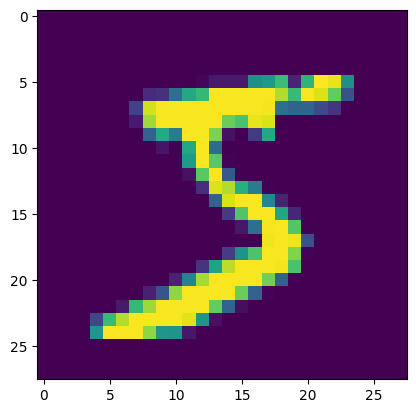

In [8]:
plt.imshow(mnist_trainset.data[0,:,:])
plt.show()

In [9]:
data_vec = torch.reshape(mnist_trainset.data, (60000, 28*28)) # Make into vector

### Rather than estimating it directly using maximum likelihood, start by 
- estimating the data covariance matrix
- calculate the eigenvectors and eigenvalues
- to initialize 𝑊 (12.45)
- Then use eq 12.46 to calculate 𝜎

In [10]:
data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eig(data_cov)

$W = U_M (L_M - \sigma^2 I)^{1/2}$  
U_M is DxM with columns being a subset of M eigenvectors of the covariance matrix.  
L_M is MxM diagonal with corresponding eigenvalues.  

In [11]:
D = data_eig.eigenvectors.shape[1]
M = 2
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[2:])

In [12]:
U_M = data_eig.eigenvectors[:,:2]
L_M = torch.diag(data_eig.eigenvalues[:2])

In [13]:
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)

## 𝜇 is given by the population mean.

In [14]:
data_vec_double = data_vec.type(torch.DoubleTensor)

In [15]:
mu = torch.mean(data_vec_double, 0)

### Now evaluate and plot the expected value of z given x for all your input images.

$p(z|x) = N(z | M^{-1}W^T(x-\mu), \sigma^{-2}M)$  
$M = W^T W + \sigma^2 I$

In [16]:
M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)

In [17]:
x_mu = data_vec_double.T - mu.repeat(N,1).T

In [18]:
temp = torch.inverse(M)@W.T

In [19]:
temp_double = temp.type(torch.double)

/var/folders/3m/t5ftv_1d5tj5szs3txjmqx7w0000gn/T/ipykernel_10578/3706780267.py:1: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:299.)
  temp_double = temp.type(torch.double)


In [20]:
z_values = temp_double@x_mu

### Color the points by the digit labels. Does the Probabilistic PCA latent space separate the 10 digits?

It is best at 0 and 1 the rest are more overlapping. But some tendencies are seen.

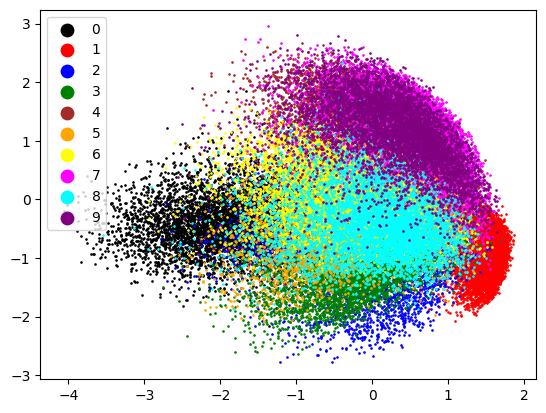

In [22]:
results_for_plot = z_values.detach().numpy().T

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = mnist_trainset.targets

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.savefig('e3_ppca.png')
plt.show()